In [ ]:
import torch
import os
from torchvision import datasets, transforms
import torch.nn as nn
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from utils import plot_tsne, tensors_as_images, dataset_first_n, plot_fit
import random
import argparse
import itertools

import IPython.display


import mnist_nets
import training

NUM_CLASSES = 10
EPOCHS = 100

In [2]:
def freeze_seeds(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


In [3]:
args = argparse.Namespace()
args.seed = 0
args.data_path = "/datasets/cv_datasets/data"
args.batch_size = 32
args.latent_dim = 128
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.mnist = True
args.self_supervised = False

In [4]:
freeze_seeds(args.seed)

In [5]:

if args.mnist:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.1307], std=[0.3081])  
    ])
    train_dataset = datasets.MNIST(root=args.data_path, train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root=args.data_path, train=False, download=True, transform=transform)
else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])  
    ])
    train_dataset = datasets.CIFAR10(root=args.data_path, train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root=args.data_path, train=False, download=True, transform=transform)

(<Figure size 1000x1000 with 10 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

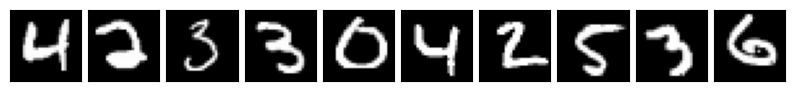

In [6]:

dataset_first_n(train_dataset, 10, figsize=(10,10), nrows=1, cmap='gray')

In [7]:


#Data
# When you create your dataloader you should split train_dataset or test_dataset to leave some aside for validation
ds_val, ds_train = torch.utils.data.random_split(train_dataset, [0.2, 0.8])

# ds_train = torch.utils.data.Subset(ds_train, range(100))


dl_train = torch.utils.data.DataLoader(ds_train, batch_size=args.batch_size, shuffle=True)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=args.batch_size, shuffle=False)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

dl_sample = itertools.cycle(torch.utils.data.DataLoader(ds_train, batch_size=7, shuffle=True))

img_shape = train_dataset[0][0].shape



In [ ]:

#Model
model = mnist_nets.AE(img_shape, args.latent_dim).to(args.device)
model_dp = torch.nn.DataParallel(model)

# imgs, _ = next(dl_sample)
# imgs = imgs.to(args.device)
# model.sample(imgs)


#Optimizer
optimizer = torch.optim.Adam(model.parameters())

#Loss
loss_fn = torch.nn.L1Loss()

#Trainer
trainer = training.AETrainer(model_dp, loss_fn, optimizer, args.device)

checkpoint_file = 'checkpoints/mnist_ae'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

In [9]:

# imgs, _ = next(dl_sample)

# model.sample(imgs)

# for name, param in model.named_parameters():
#     print(f"{name}: requires_grad = {param.requires_grad}")


In [10]:

model

AE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.01)
      (5): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): LeakyReLU(negative_slope=0.01)
      (8): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=432, out_features=128, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=128, out_features=432, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Unflatten(dim=1, unflattened_size

In [11]:
def post_epoch_fn(epoch, train_result, test_result, verbose):
    # Plot some samples if this is a verbose epoch
    if verbose:
        imgs, _ = next(dl_sample)
        imgs = imgs.to(args.device)
        recon_imgs = model.sample(imgs)

        fig, _ = tensors_as_images(list(imgs), figsize=(6,3),cmap='gray')
        IPython.display.display(fig)
        plt.close(fig)

        fig, _ = tensors_as_images(list(recon_imgs), figsize=(6,3), cmap='gray')
        IPython.display.display(fig)
        plt.close(fig)

--- EPOCH 1/100 ---
test_batch (Avg. Loss 0.249, Accuracy 12.6): 100%|██████████| 375/375 [00:05<00:00, 63.48it/s]
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 1


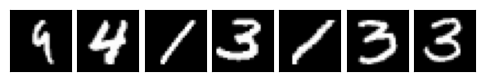

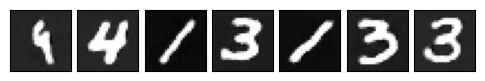

*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 2
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 3
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 4
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 5
--- EPOCH 6/100 ---
test_batch (Avg. Loss 0.223, Accuracy 14.1): 100%|██████████| 375/375 [00:06<00:00, 56.82it/s]
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 6


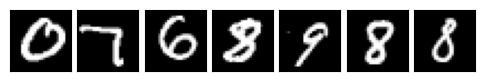

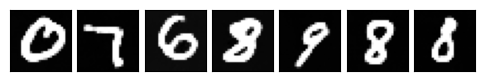

*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 7
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 8
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 9
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 10
--- EPOCH 11/100 ---
test_batch (Avg. Loss 0.217, Accuracy 14.4): 100%|██████████| 375/375 [00:06<00:00, 59.79it/s]


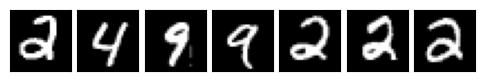

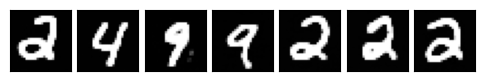

*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 12
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 13
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 14
--- EPOCH 16/100 ---
test_batch (Avg. Loss 0.215, Accuracy 14.6): 100%|██████████| 375/375 [00:06<00:00, 61.98it/s]
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 16


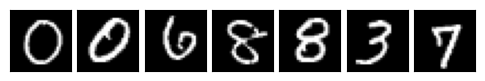

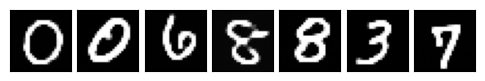

*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 17
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 18
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 20
--- EPOCH 21/100 ---
test_batch (Avg. Loss 0.213, Accuracy 14.7): 100%|██████████| 375/375 [00:06<00:00, 55.58it/s]
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 21


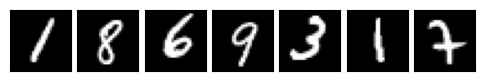

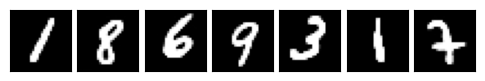

*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 22
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 23
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 24
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 25
--- EPOCH 26/100 ---
test_batch (Avg. Loss 0.212, Accuracy 14.8): 100%|██████████| 375/375 [00:07<00:00, 53.21it/s]
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 26


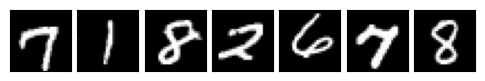

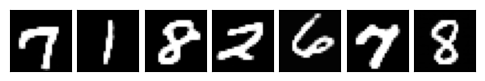

*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 27
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 28
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 29
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 30
--- EPOCH 31/100 ---
test_batch (Avg. Loss 0.212, Accuracy 14.8): 100%|██████████| 375/375 [00:06<00:00, 62.24it/s]
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 31


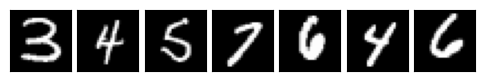

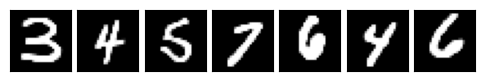

*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 32
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 33
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 34
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 35
--- EPOCH 36/100 ---
test_batch (Avg. Loss 0.211, Accuracy 14.9): 100%|██████████| 375/375 [00:06<00:00, 59.91it/s]


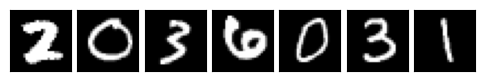

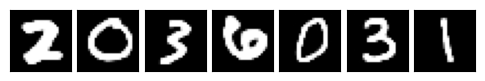

*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 37
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 40
--- EPOCH 41/100 ---
test_batch (Avg. Loss 0.211, Accuracy 14.9): 100%|██████████| 375/375 [00:06<00:00, 57.89it/s]
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 41


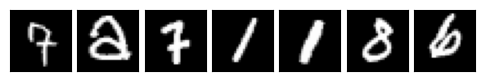

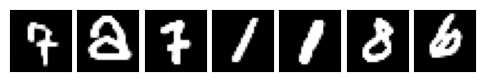

*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 44
--- EPOCH 46/100 ---
test_batch (Avg. Loss 0.210, Accuracy 14.9): 100%|██████████| 375/375 [00:06<00:00, 57.59it/s]
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 46


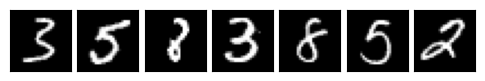

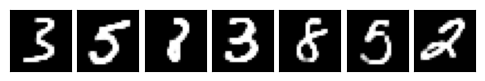

*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 47
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 49
--- EPOCH 51/100 ---
test_batch (Avg. Loss 0.210, Accuracy 14.9): 100%|██████████| 375/375 [00:06<00:00, 61.68it/s]
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 51


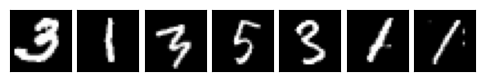

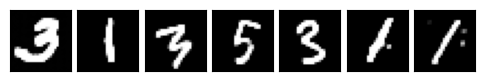

*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 52
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 54
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 55
--- EPOCH 56/100 ---
test_batch (Avg. Loss 0.210, Accuracy 15.0): 100%|██████████| 375/375 [00:06<00:00, 62.01it/s]
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 56


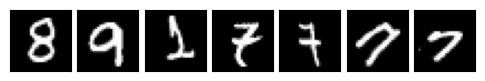

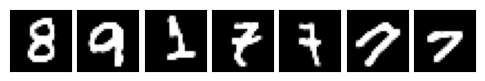

--- EPOCH 61/100 ---
test_batch (Avg. Loss 0.210, Accuracy 15.0): 100%|██████████| 375/375 [00:05<00:00, 65.28it/s]
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 61


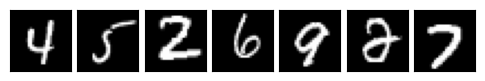

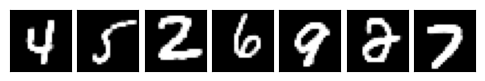

*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 62
--- EPOCH 66/100 ---
test_batch (Avg. Loss 0.210, Accuracy 15.0): 100%|██████████| 375/375 [00:06<00:00, 56.65it/s]


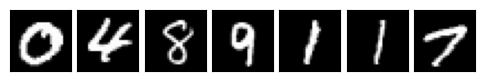

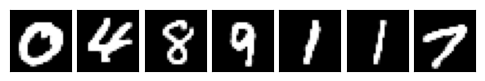

*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 69
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 70
--- EPOCH 71/100 ---
test_batch (Avg. Loss 0.209, Accuracy 15.0): 100%|██████████| 375/375 [00:05<00:00, 62.71it/s]
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 71


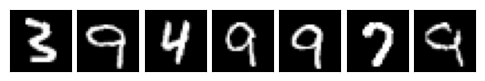

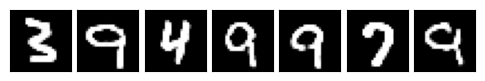

*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 75
--- EPOCH 76/100 ---
test_batch (Avg. Loss 0.209, Accuracy 15.0): 100%|██████████| 375/375 [00:06<00:00, 61.95it/s]
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 76


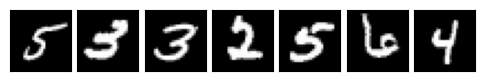

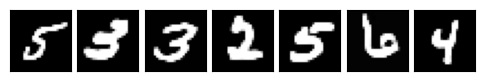

*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 80
--- EPOCH 81/100 ---
test_batch (Avg. Loss 0.209, Accuracy 15.0): 100%|██████████| 375/375 [00:06<00:00, 61.60it/s]
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 81


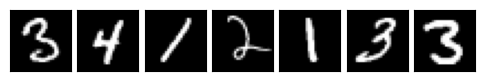

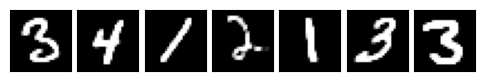

--- EPOCH 86/100 ---
test_batch (Avg. Loss 0.209, Accuracy 15.0): 100%|██████████| 375/375 [00:06<00:00, 59.18it/s]
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 86


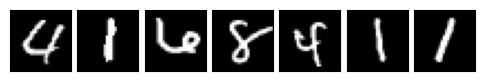

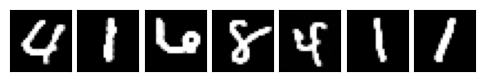

*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 88
--- EPOCH 91/100 ---
test_batch (Avg. Loss 0.209, Accuracy 15.0): 100%|██████████| 375/375 [00:06<00:00, 54.75it/s]


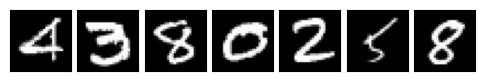

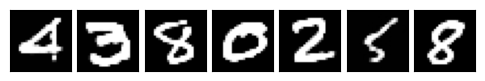

*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 92
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 94
*** Saved checkpoint checkpoints/mnist_ae.pt at epoch 95
--- EPOCH 96/100 ---
test_batch (Avg. Loss 0.209, Accuracy 15.0): 100%|██████████| 375/375 [00:06<00:00, 60.77it/s]


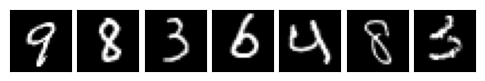

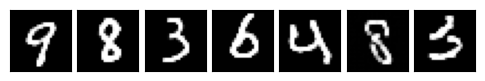

--- EPOCH 100/100 ---
test_batch (Avg. Loss 0.209, Accuracy 15.0): 100%|██████████| 375/375 [00:06<00:00, 58.20it/s]


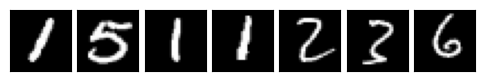

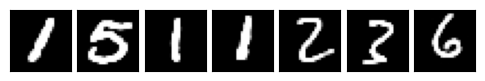

In [12]:

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    checkpoint_file = checkpoint_file_final
else:
    res = trainer.fit(dl_train, dl_val,
                      num_epochs=EPOCHS, early_stopping=10, print_every=5,
                      checkpoints=checkpoint_file,
                      post_epoch_fn=post_epoch_fn)


C:\Users\matan\AppData\Local\Temp\ipykernel_14728\3243652837.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state = torch.load(f'{checkpoint_file}.pt', map_locati

*** Images reconstructed from best model:


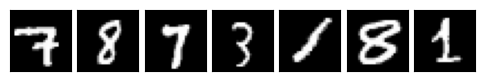

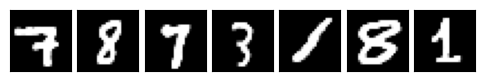

*** Best model mean abs error: 0.2087


In [ ]:

# Plot images from best model
saved_state = torch.load(f'{checkpoint_file}.pt', map_location=args.device)
model_dp.load_state_dict(saved_state['model_state'])

print('*** Images reconstructed from best model:')
imgs, _ = next(dl_sample)
imgs = imgs.to(args.device)
recon_imgs = model.sample(imgs)

fig, _ = tensors_as_images(list(imgs), figsize=(6,3), cmap='gray')
IPython.display.display(fig)
plt.close(fig)

fig, _ = tensors_as_images(list(recon_imgs), figsize=(6,3), cmap='gray')
IPython.display.display(fig)
plt.close(fig)


In [ ]:
# checking best model MAE
trainer.loss_fn = torch.nn.L1Loss()
res = trainer.test_epoch(dl_test)
recon_mae = sum(res.losses) / len(res.losses)

print(f'*** Best model mean abs error: {recon_mae:.4f}')

test_batch (Avg. Loss 0.297, Accuracy 10.6): 100%|██████████| 313/313 [00:04<00:00, 65.63it/s]
*** Best model mean abs error: 0.2972


In [14]:
encoder = model_dp.module.encoder
for param in encoder.parameters():
    param.requires_grad = False  # Freezes encoder


In [ ]:
#Model
classifier = mnist_nets.Classifier(encoder,args.latent_dim, NUM_CLASSES).to(args.device)
# classifier_dp = torch.nn.DataParallel(classifier)

#Optimizer
optimizer = torch.optim.Adam(classifier.parameters())

#Loss
loss_fn = torch.nn.CrossEntropyLoss()

#Trainer
trainer = training.ClassifierTrainer(classifier, loss_fn, optimizer, args.device)

checkpoint_file = 'checkpoints/mnist_classifier'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

--- EPOCH 1/100 ---
test_batch (Avg. Loss 0.328, Accuracy 90.6): 100%|██████████| 375/375 [00:05<00:00, 72.46it/s]
*** Saved checkpoint checkpoints/mnist_classifier.pt at epoch 1
*** Saved checkpoint checkpoints/mnist_classifier.pt at epoch 2
*** Saved checkpoint checkpoints/mnist_classifier.pt at epoch 3
*** Saved checkpoint checkpoints/mnist_classifier.pt at epoch 4
*** Saved checkpoint checkpoints/mnist_classifier.pt at epoch 5
--- EPOCH 6/100 ---
test_batch (Avg. Loss 0.155, Accuracy 95.5): 100%|██████████| 375/375 [00:04<00:00, 78.85it/s]
*** Saved checkpoint checkpoints/mnist_classifier.pt at epoch 6
*** Saved checkpoint checkpoints/mnist_classifier.pt at epoch 7
*** Saved checkpoint checkpoints/mnist_classifier.pt at epoch 8
*** Saved checkpoint checkpoints/mnist_classifier.pt at epoch 9
*** Saved checkpoint checkpoints/mnist_classifier.pt at epoch 10
--- EPOCH 11/100 ---
test_batch (Avg. Loss 0.115, Accuracy 96.6): 100%|██████████| 375/375 [00:04<00:00, 80.40it/s]
*** Saved che

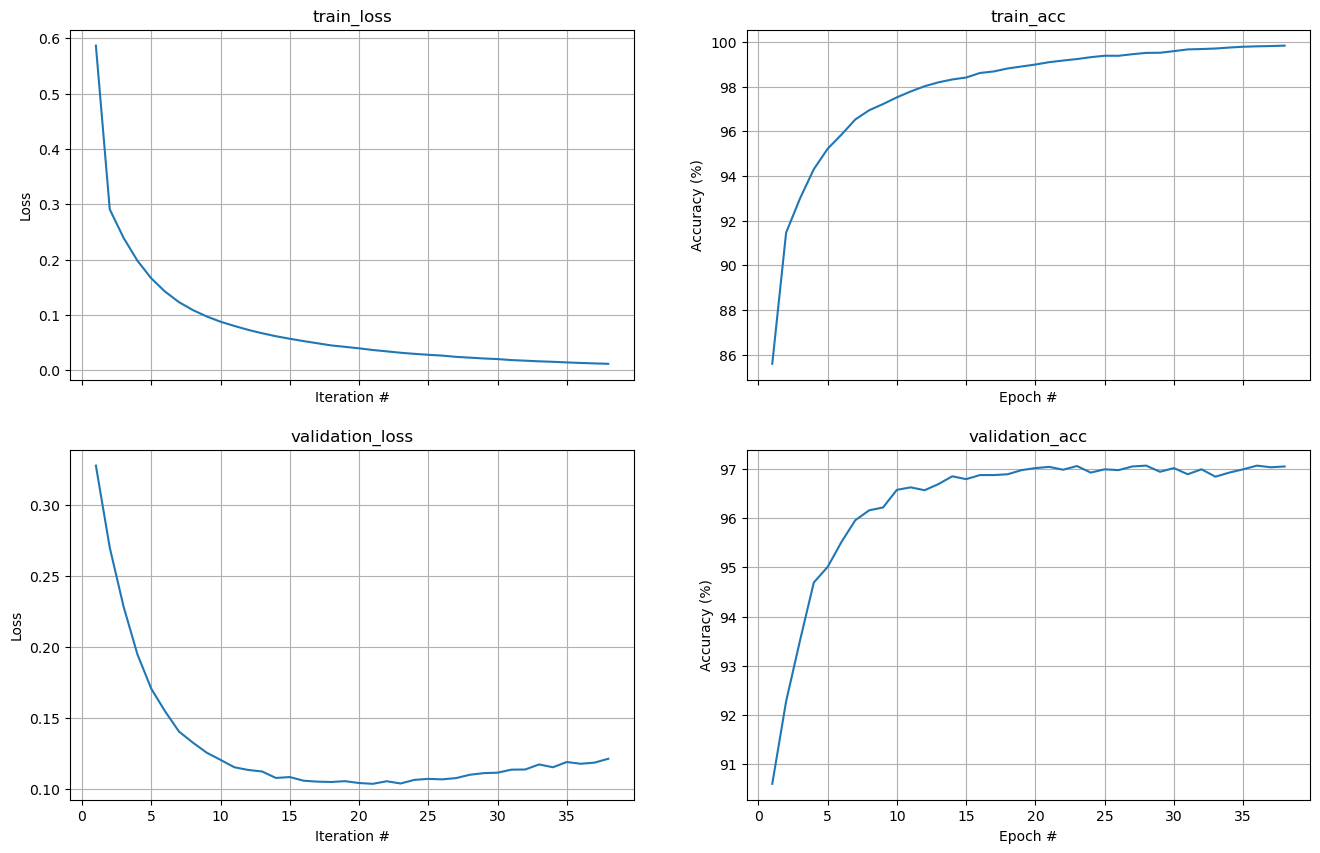

In [16]:

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    checkpoint_file = checkpoint_file_final
else:
    res = trainer.fit(dl_train, dl_val,
                      num_epochs=EPOCHS, early_stopping=10, print_every=5,
                      checkpoints=checkpoint_file,)
    plot_fit(res)

# Evaluation


##  2. Quantitative Results

*** results from best model:


C:\Users\matan\AppData\Local\Temp\ipykernel_14728\1990524677.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state = torch.load(f'{checkpoint_file}.pt', map_locati

(<Figure size 1600x1000 with 4 Axes>,
 array([<Axes: title={'center': 'train_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <Axes: title={'center': 'train_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>,
        <Axes: title={'center': 'validation_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <Axes: title={'center': 'validation_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>],
       dtype=object))

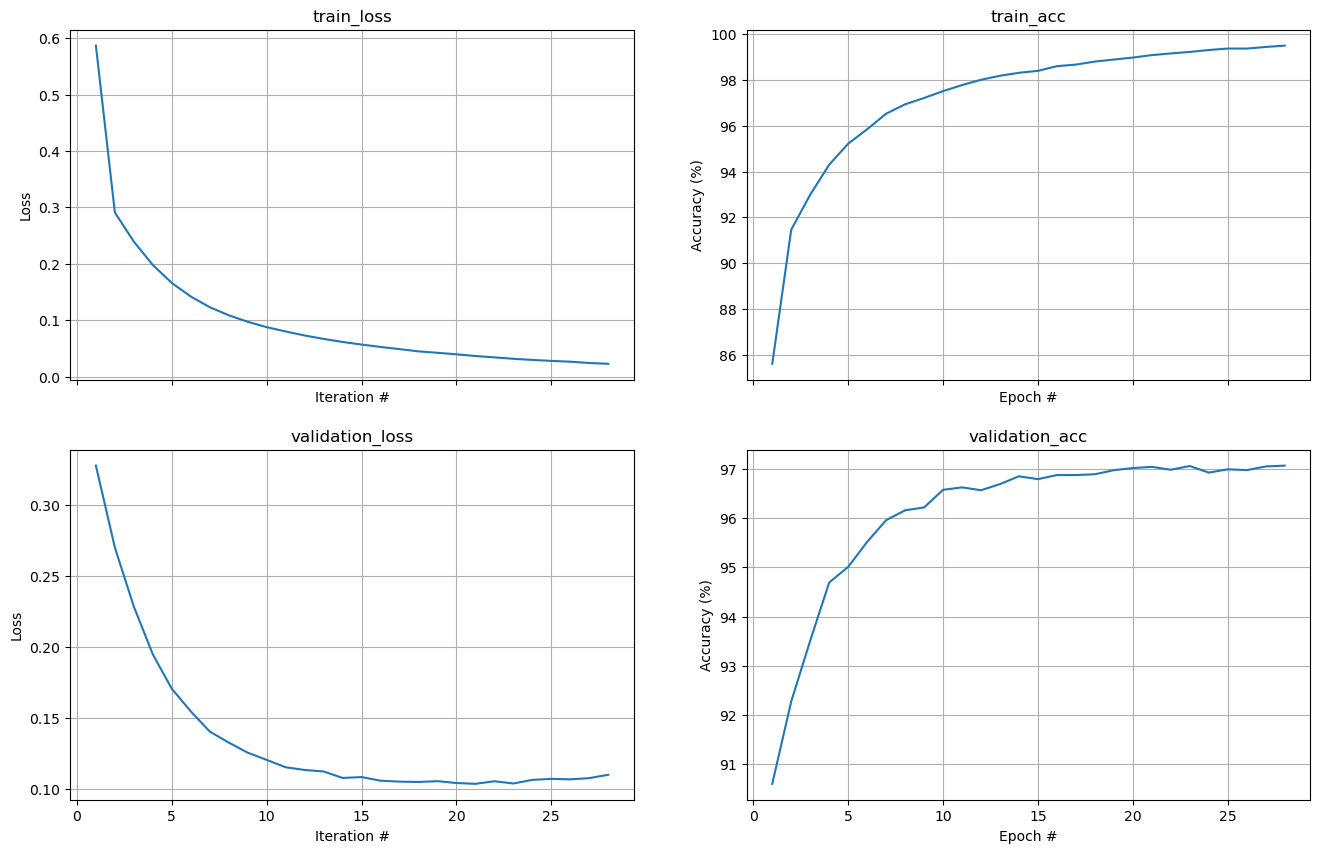

In [17]:

print('*** results from best model:')
saved_state = torch.load(f'{checkpoint_file}.pt', map_location=args.device)
res = saved_state['fit_result']
plot_fit(res)   

In [ ]:

res = trainer.test_epoch(dl_test)
print(f'Accuracy on test set: {res.accuracy:.2f}')
print(f' Accuracy on validation set: {saved_state['best_epoch_test_acc']}')
print(f' Accuracy on training set: {saved_state['best_epoch_train_acc']}')
print(f'Best model mean abs error: {recon_mae:.4f}')

test_batch (Avg. Loss 1.407, Accuracy 50.5): 100%|██████████| 313/313 [00:03<00:00, 82.88it/s]
Accuracy on test set: 50.46
Best model mean abs error: 0.2972


##  3. Qualitative Results

*** Images reconstructed from best model:


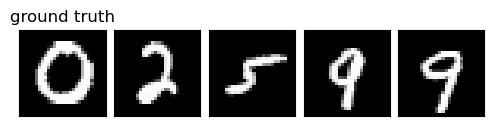

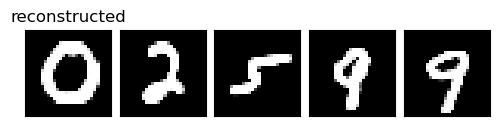

In [19]:
dl_sample = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=True)
print('*** Images reconstructed from best model:')
imgs, _ = next(iter(dl_sample))
imgs = imgs.to(args.device)
recon_imgs = model.sample(imgs)

fig, _ = tensors_as_images(list(imgs), figsize=(6,3), cmap='gray', titles=['ground truth'])
IPython.display.display(fig)
plt.close(fig)

fig, _ = tensors_as_images(list(recon_imgs), figsize=(6,3), cmap='gray', titles=['reconstructed'])
IPython.display.display(fig)
plt.close(fig)


## 4. Linear Interpolation

(<Figure size 600x300 with 2 Axes>,
 array([<Axes: title={'center': 'ground truth'}>, <Axes: >], dtype=object))

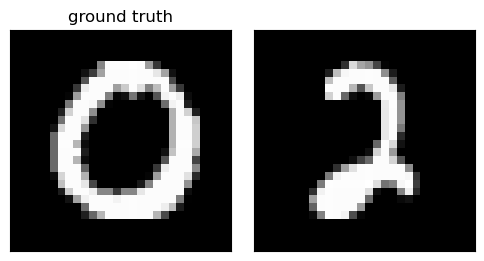

In [20]:
imgs = imgs[:2]
tensors_as_images(list(imgs), figsize=(6,3), cmap='gray', titles=['ground truth'])

(<Figure size 600x300 with 10 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

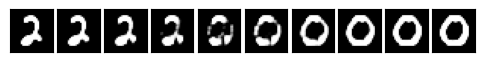

In [21]:
model.eval()

with torch.no_grad():
    z1, z2 = model.encoder(imgs)

alphas = np.linspace(0, 1, 10)
z1 = z1.unsqueeze(0) 
z2 = z2.unsqueeze(0) 

alphas = torch.tensor(np.linspace(0, 1, 10), dtype=torch.float32).view(-1, 1) 

z_interp = alphas * z1 + (1 - alphas) * z2 

with torch.no_grad():
    recon_imgs = model.decoder(z_interp)


tensors_as_images(list(recon_imgs), figsize=(6, 3), cmap='gray')


## 5. t-SNE

In [ ]:
img_file = f"tsne_images/{checkpoint_file.replace('checkpoints/','')}"
if not os.path.isfile(f'{img_file}_latent_tsne.png'):
    plot_tsne(classifier.encoder, dl_test, args.device, img_file)

c:\Users\matan\.conda\envs\cs236781-tutorials\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\matan\.conda\envs\cs236781-tutorials\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\matan\.conda\envs\cs236781-tutorials\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\matan\.conda\envs\cs236781-tutorials\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


: 